## Import necessary packages

In [1]:
# Use DL_Track_US env

import os
import pandas as pd
import numpy as np
import tensorflow

import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

from sklearn.model_selection import KFold
import cv2

import tensorflow as tf
from tensorflow.keras.backend import clear_session
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, CSVLogger
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import MeanIoU

#unet collection
#from keras_unet_collection import models
from models import *
#import tensorflow as tf
from PIL import Image

ModuleNotFoundError: No module named 'models'

In [2]:
# Check if TensorFlow is built with GPU support
print("Built with GPU support:", tf.test.is_built_with_cuda())

# List available physical devices (CPU/GPU)
physical_devices = tf.config.list_physical_devices('GPU')

if len(physical_devices) > 0:
    print(f"Number of GPUs available: {len(physical_devices)}")
    for i, gpu in enumerate(physical_devices):
        print(f"GPU {i}: {gpu}")
else:
    print("No GPU available.")

Built with GPU support: True
Number of GPUs available: 1
GPU 0: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [3]:
from tensorflow.keras import mixed_precision

# Set the mixed precision policy to 'mixed_float16'
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)

# Print the current policy to confirm
print("Mixed precision policy set to:", mixed_precision.global_policy())



INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3080 Ti Laptop GPU, compute capability 8.6
Mixed precision policy set to: <Policy "mixed_float16">


## General part

In [2]:
#define directory where images and masks are located on local disk
image_directory = 'C:/Users/admin/Documents/DeepACSA/temporary/BFRHL_model/apo_image_csa_VL/insert_images/' ##VGG16 needs seperate induction of path
mask_directory = 'C:/Users/admin/Documents/DeepACSA/temporary/BFRHL_model/apo_masks_csa_VL/insert_masks/'   ##VGG16 need seperate induction of path
#define the properties and empty list for resized images and masks
SIZE = 256
image_dataset = []
mask_dataset = []

#define custom function
def IoU(y_true, y_pred, dtype=tf.float32):
    y_pred = tf.cast(y_pred, dtype)
    y_true = tf.cast(y_true, y_pred.dtype)

    y_pred = tf.squeeze(y_pred)
    y_true = tf.squeeze(y_true)

    y_true_pos = tf.reshape(y_true, [-1])
    y_pred_pos = tf.reshape(y_pred, [-1])

    area_intersect = tf.reduce_sum(tf.multiply(y_true_pos, y_pred_pos))
    
    area_true = tf.reduce_sum(y_true_pos)
    area_pred = tf.reduce_sum(y_pred_pos)
    area_union = area_true + area_pred - area_intersect
    
    # Return the IoU score
    return tf.math.divide_no_nan(area_intersect, area_union)

def iou_seg(y_true, y_pred, dtype=tf.float32):
    y_pred = tf.cast(y_pred, dtype)
    y_true = tf.cast(y_true, y_pred.dtype)

    y_pred = tf.squeeze(y_pred)
    y_true = tf.squeeze(y_true)

    y_true_pos = tf.reshape(y_true, [-1])
    y_pred_pos = tf.reshape(y_pred, [-1])

    area_intersect = tf.reduce_sum(tf.multiply(y_true_pos, y_pred_pos))
    
    area_true = tf.reduce_sum(y_true_pos)
    area_pred = tf.reduce_sum(y_pred_pos)
    area_union = area_true + area_pred - area_intersect
    
    # IoU score
    iou = tf.math.divide_no_nan(area_intersect, area_union)

    # IoU loss (1 - IoU)
    return 1 - iou

def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1 - score

def dice_score(y_true, y_pred, smooth=1):
    
    # Flatten
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)
    return score

def dice_coef_loss(y_true, y_pred):
    
    return 1 - dice_score(y_true, y_pred)

def dice_bce_score(y_true, y_pred, smooth=1):    
    
    Dice_BCE = K.binary_crossentropy(y_true, y_pred)   + dice_loss(y_true, y_pred)
    
    return Dice_BCE

def focal_loss(y_true, y_pred, alpha=0.8, gamma=2):    
      
    BCE = K.binary_crossentropy(y_true, y_pred)
    BCE_EXP = K.exp(-BCE)
    focal_loss = K.mean(alpha * K.pow((1-BCE_EXP), gamma) * BCE)
    return focal_loss

def tversky(y_true, y_pred, smooth=1, alpha=0.7):
    y_true_pos = K.flatten(y_true)
    y_pred_pos = K.flatten(y_pred)
    true_pos = K.sum(y_true_pos * y_pred_pos)
    false_neg = K.sum(y_true_pos * (1 - y_pred_pos))
    false_pos = K.sum((1 - y_true_pos) * y_pred_pos)
    return (true_pos + smooth) / (true_pos + alpha * false_neg + (1 - alpha) * false_pos + smooth)


def tversky_loss(y_true, y_pred):
    return 1 - tversky(y_true, y_pred)


def focal_tversky_loss(y_true, y_pred, gamma=0.75):
    tv = tversky(y_true, y_pred)
    return K.pow((1 - tv), gamma)

# Plot sample of model prediction
def plot_sample(X, y, preds, binary_preds, ix=None):
    if ix is None:
        ix = random.randint(0, len(X))

    fig, ax = plt.subplots(1, 4, figsize=(30, 20))
    ax[0].imshow(X[ix, ..., 0], cmap='Greys_r')
    
    ax[0].set_title('US-image', c="white" )
    ax[0].grid(False)

    ax[1].imshow(y[ix].squeeze(), cmap='Greys_r')
    ax[1].set_title('Aponeurosis', c="white")
    ax[1].grid(False)

    ax[2].imshow(preds[ix].squeeze(), vmin=0, vmax=1, cmap="Greys_r")
    
    ax[2].set_title('Apo-Predicted', c="white")
    ax[2].grid(False)
    
    ax[3].imshow(binary_preds[ix].squeeze(), vmin=0, vmax=0.5, cmap="Greys_r")
    
    ax[3].set_title('Apo-Picture binary', c="white")
    ax[3].grid(False)
    
    plt.savefig(str(ix)+"Pred_area.tif")

# Save all predictions on disk 
def save_pred_area(binary_preds): 
    for i in range(len(binary_preds)): 
        fig, (ax1)= plt.subplots(1, 1, figsize = (15, 15))
        ax1.imshow(binary_preds[i], cmap="Greys_r", interpolation="bilinear")
        ax1.set_title("Predicted Area")
        plt.savefig(str(i)+"Pred_area.tif") # Saves images to directory of notebook

#enumerate and resize images/masks
masks = os.listdir(mask_directory)
for i, image_name in enumerate(masks):
    if (image_name.split('.')[1] == 'tif'):
        image = cv2.imread(mask_directory+image_name, 0)
        image = Image.fromarray(image)
        image = image.resize((SIZE, SIZE))
        image = np.array(image).astype('float32')
        mask_dataset.append(np.array(image))

images = os.listdir(image_directory)
for i, image_name in enumerate(images):    #enumerate method adds a counter and returns the enumerate object
    if (image_name.split('.')[1] == 'tif'):
        #print(image_directory+image_name)
        image = cv2.imread(image_directory+image_name, 1)
        image = Image.fromarray(image)
        image = image.resize((SIZE, SIZE))
        image = np.array(image).astype('float32')
        image_dataset.append(np.array(image))



#define some hyperparameters
num_labels = 1  #Binary classificaion
batch_size = 1  #keep it smaller than 3
epochs = 60 #60 
num_folds = 5   #define the number of folds (usually 5-10 folds)

#normalize images
image_dataset = np.array(image_dataset)/255
print(len(image_dataset))
#do not normalize masks, just rescale to 0 to 1. Add RGB-Chanel (3) to mask.
mask_dataset = np.expand_dims((np.array(mask_dataset)),3)/255
print(len(mask_dataset))

#define the K-fold Cross Validator
kfold = KFold(n_splits=num_folds, random_state= 42 ,shuffle=True)

#define per-fold score containers 
acc_per_fold = []
loss_per_fold = []
IoU_per_fold = []

fold_no = 1

#determine best fold and create csv file
def best_fold(searchterm):
    fo_path = os.getcwd() 
    max_val_iou = 0.0
    fold = ""
    for file_name in os.listdir(fo_path):
        if searchterm in file_name and file_name.endswith(".csv"):
            file_path = os.path.join(fo_path, file_name)
            df = pd.read_csv(file_path)
            print(file_path)
            if "val_IoU" in df.columns:
                val_iou = df["val_IoU"].max()
            if val_iou > max_val_iou:
                max_val_iou = val_iou
                fold = file_name

    #save the results to a CSV file
    results = pd.DataFrame({"fold": [fold], "max_val_iou": [max_val_iou]})
    results.to_csv(f"{searchterm}results.csv", index=False)

1977
1977


## Visualization of the data

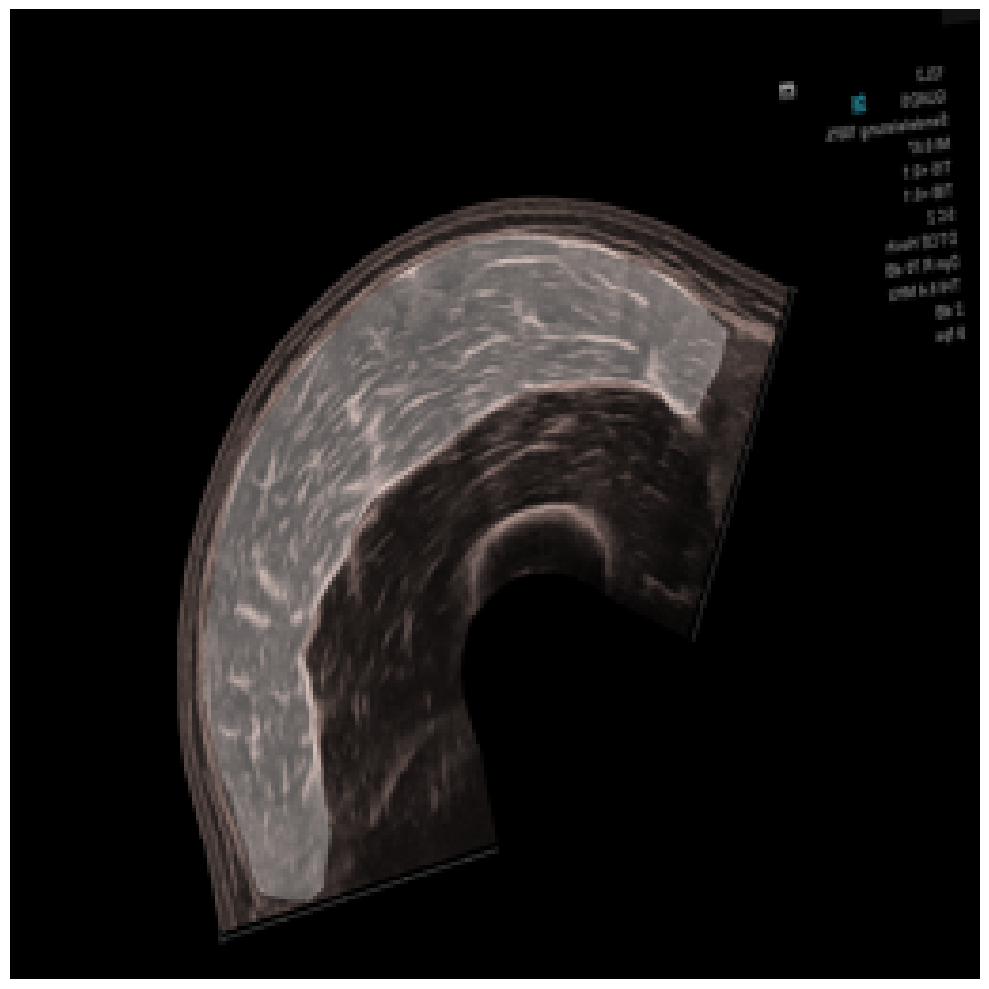

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import random

# Function to plot a random image with its corresponding mask overlay
def plot_random_image_with_mask_overlay(x_train, y_train):
    # Flatten the list of all images and masks for easy random selection

    random_index = random.randint(min(range(len(x_train))), max(range(len(x_train))))     
    # Retrieve the corresponding image and mask
    random_image = x_train[random_index]  # Select the middle frame from the stack
    random_mask = y_train[random_index]  # Assume a single channel mask
    
    # Plot the image with its mask overlay
    plt.figure(figsize=(15, 10))
    plt.imshow(random_image, cmap='gray')
    plt.axis('off')

    plt.imshow(random_image, cmap='gray')
    plt.imshow(random_mask, cmap='gray', alpha=0.3)  # Overlay the mask with some transparency
    plt.axis('off')

    plt.tight_layout()
    plt.show()

# Call the function to plot an image with its mask overlay
plot_random_image_with_mask_overlay(image_dataset, mask_dataset)

# Image Augmentation

In [3]:
## Input image & mask folder variables and prefix for saved augmented images
# Change before augmentation
input_img_folder = 'C:/Users/admin/Documents/DeepACSA/temporary/BFRHL_model/apo_image_csa_VL/insert_images/'
input_mask_folder = 'C:/Users/admin/Documents/DeepACSA/temporary/BFRHL_model/apo_masks_csa_VL/insert_masks/'
img_aug_prefix = "aug"


# Creating image augmentation function
gen = ImageDataGenerator(rotation_range=10, 
                        width_shift_range=0.01, 
                        height_shift_range=0.01,
                        zoom_range=0.05,
                        horizontal_flip=True)

ids = os.listdir(input_img_folder)
seed = 42
batch_size = 2
num_aug_images = 2 # Number of images added from augmented dataset. 


for i in range(int(len(ids))):
    
    # Choose image & mask that should be augmented 
    # Directory structur: "root/some_dorectory/"
    chosen_image = ids[i] 
    image_path = input_img_folder + chosen_image 
    mask_path = input_mask_folder + chosen_image
    image = np.expand_dims(plt.imread(image_path),0)# Read and expand image dimensions
    if image.ndim < 4: 
        image = np.expand_dims(image,-1)
    mask = np.expand_dims(plt.imread(mask_path),0)
    if mask.ndim < 4: 
        mask = np.expand_dims(mask,-1)

    # Augment images 
    aug_image = gen.flow(image, batch_size=batch_size, seed=seed, save_to_dir=input_img_folder, save_prefix=img_aug_prefix+str(i), save_format="tif")
    aug_mask = gen.flow(mask, batch_size=batch_size, seed=seed, save_to_dir=input_mask_folder, save_prefix=img_aug_prefix+str(i), save_format="tif")
    seed = seed + 1 
     
    # Add images to folder
    for i in range(num_aug_images):
        next(aug_image)[0].astype(np.uint8)
        next(aug_mask)[0].astype(np.uint8)

## Visualize Predictions

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import Callback

class PredictionVisualizer(Callback):
    def __init__(self, validation_data, n_images=5):
        super().__init__()
        self.validation_data = validation_data
        self.n_images = n_images

    def on_epoch_end(self, epoch, logs=None):
        val_images, val_masks = self.validation_data
        predictions = self.model.predict(val_images)

        # Select a few random samples
        indices = np.random.choice(len(val_images), self.n_images, replace=False)

        plt.figure(figsize=(20, 10))
        for i, idx in enumerate(indices):
            plt.subplot(3, self.n_images, i + 1)
            plt.imshow(val_images[idx], cmap='gray')
            plt.title("Input Image")
            plt.axis("off")

            plt.subplot(3, self.n_images, i + 1 + self.n_images)
            plt.imshow(val_masks[idx, ..., 0], cmap='gray')
            plt.title("Ground Truth Mask")
            plt.axis("off")

            plt.subplot(3, self.n_images, i + 1 + 2 * self.n_images)
            plt.imshow(predictions[idx, ..., 0], cmap='gray')
            plt.title("Predicted Mask")
            plt.axis("off")

        plt.tight_layout()
        plt.savefig(f'epoch_{epoch + 1}_predictions.png')
        plt.close()


## DL-Kfold with unet_2plus

This works now but needs at least 200 epochs

In [3]:
from keras_unet_collection.losses import focal_tversky

epochs = 200


architecture = "unet2plus_"
for train, test in kfold.split(image_dataset, mask_dataset):
       
  callbacks = [
    EarlyStopping(patience=20, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=10, min_lr=0.00000001, verbose=1),
    ModelCheckpoint(filepath=f"K-foldno{fold_no}-unet2plus-VL-V1-BFRHL.h5", verbose=1, save_best_only=True, save_weights_only=False), # Give the model a name (the .h5 part)
    CSVLogger(f"K-foldno{fold_no}-unet2plus-VL-V1-BFRHL.csv", separator=",", append=False)]

  #define the model architecture
  #unet_plus_2d requires a Backbone
  model = unet_plus_2d((256, 256, 3), filter_num=[64, 128, 256, 512, 1024], 
                           n_labels=1, 
                           stack_num_down=2, stack_num_up=2, 
                           activation="ReLU", 
                           output_activation="Sigmoid", 
                           batch_norm=True, pool=False, unpool=False, 
                           backbone="VGG19", weights="imagenet", 
                           freeze_backbone=True, freeze_batch_norm=True, 
                           name="xnet")

  #compile the model
  model.compile(loss="binary_crossentropy", optimizer=Adam(learning_rate= 1e-5), 
              metrics=["accuracy", IoU])
  
  #generate a print
  print("------------------------------------------------------------------------")
  print(f"Training for fold {fold_no} ...")

  #fit model to data
  Unet_plus_history = model.fit(image_dataset[train], mask_dataset[train], 
                    verbose=1,
                    batch_size = 2,
                    validation_data=(image_dataset[test], mask_dataset[test]), 
                    shuffle=False,
                    epochs=epochs,
                    callbacks=callbacks)
  
  #append evaluation values for every fold to a list
  acc_per_fold.append(model.evaluate(image_dataset[test], mask_dataset[test])[1])
  loss_per_fold.append(model.evaluate(image_dataset[test], mask_dataset[test])[0])
  IoU_per_fold.append(model.evaluate(image_dataset[test], mask_dataset[test])[2])

  #increase fold number
  fold_no += 1

  clear_session()

fold_no = 1
#determine best fold
best_fold(architecture)


c:\Users\admin\miniconda3\envs\DL_Track_US\lib\site-packages\keras_unet_collection\_backbone_zoo.py:45: UserWarning: 

Backbone VGG19 does not use batch norm, but other layers received batch_norm=True
  warnings.warn(param_mismatch);


------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/200
791/791 [==============================] - ETA: 0s - loss: 0.2483 - accuracy: 0.9337 - IoU: 0.2873
Epoch 1: val_loss improved from inf to 0.12234, saving model to K-foldno1-unet2plus-VL-V1-BFRHL.h5
791/791 [==============================] - 69s 81ms/step - loss: 0.2483 - accuracy: 0.9337 - IoU: 0.2873 - val_loss: 0.1223 - val_accuracy: 0.9688 - val_IoU: 0.4115 - lr: 1.0000e-05
Epoch 2/200
791/791 [==============================] - ETA: 0s - loss: 0.1195 - accuracy: 0.9690 - IoU: 0.4178
Epoch 2: val_loss improved from 0.12234 to 0.10261, saving model to K-foldno1-unet2plus-VL-V1-BFRHL.h5
791/791 [==============================] - 64s 81ms/step - loss: 0.1195 - accuracy: 0.9690 - IoU: 0.4178 - val_loss: 0.1026 - val_accuracy: 0.9718 - val_IoU: 0.4493 - lr: 1.0000e-05
Epoch 3/200
791/791 [==============================] - ETA: 0s - loss: 0.0966 - accuracy: 0.9725 - IoU: 0.4697
Epoc

RuntimeError: Can't decrement id ref count (unable to extend file properly)

## DL-Kfold with unet_3plus

In [4]:
from keras_unet_collection.losses import focal_tversky


for train, test in kfold.split(image_dataset, mask_dataset):

  callbacks = [
    EarlyStopping(patience=8, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=4, min_lr=0.0000001, verbose=1),
    ModelCheckpoint(f'B1GC-Kfoldno{fold_no}-unet3plus_VL-V1-BFRHL.keras', verbose=1, save_best_only=True, save_weights_only=False), # Give the model a name (the .h5 part)
    CSVLogger(f'B1GC-Kfoldno{fold_no}-unet3plus_VL-V1-BFRHL.csv', separator=',', append=False)]

  # Define the model architecture
  # unet_plus_2d require depth >= 2
  model = unet_3plus_2d((256, 256, 3), n_labels=num_labels, filter_num_down=[64, 128, 256, 512, 1024], 
                             filter_num_skip='auto', filter_num_aggregate='auto', 
                             stack_num_down=2, stack_num_up=2, activation='ReLU', output_activation='Sigmoid',
                             batch_norm=True, pool=True, unpool=False, deep_supervision=True, name='unet3plus')
  # Compile the model
  model.compile(loss="binary_crossentropy", optimizer=Adam(learning_rate = 1e-4), 
              metrics=['accuracy', IoU])

  # Create a generator
  train_datagen = ImageDataGenerator()
  val_datagen = ImageDataGenerator()

  # Create flow from directory or from arrays
  train_generator = train_datagen.flow(image_dataset[train], mask_dataset[train], batch_size=1)
  val_generator = val_datagen.flow(image_dataset[test], mask_dataset[test], batch_size=1)

  # Generate a print
  print('------------------------------------------------------------------------')
  print(f'Training for fold {fold_no} ...')

  # Fit data to model
  Unet_plus_history = model.fit(train_generator, 
                    verbose=1,
                    batch_size = 1,
                    validation_data=val_generator, 
                    shuffle=False,
                    epochs=epochs,
                    callbacks=callbacks)
  
  #append evaluation values for every fold to a list
  #acc_per_fold.append(model.evaluate(image_dataset[test], mask_dataset[test])[1])
  #loss_per_fold.append(model.evaluate(image_dataset[test], mask_dataset[test])[0])
  #IoU_per_fold.append(model.evaluate(image_dataset[test], mask_dataset[test])[2])

  # Increase fold number
  fold_no += 1

  # clear session
  clear_session()

fold_no = 1
#determine best fold
best_fold("unet3plus_BFlh")

Automated hyper-parameter determination is applied with the following details:
----------
	Number of convolution filters after each full-scale skip connection: filter_num_skip = [64, 64, 64, 64]
	Number of channels of full-scale aggregated feature maps: filter_num_aggregate = 320
----------
deep_supervision = True
names of output tensors are listed as follows ("sup0" is the shallowest supervision layer;
"final" is the final output layer):

	unet3plus_output_sup0_activation
	unet3plus_output_sup1_activation
	unet3plus_output_sup2_activation
	unet3plus_output_sup3_activation
	unet3plus_output_final_activation
------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/60
1581/1581 [==============================] - ETA: 0s - loss: 2.4256 - unet3plus_output_sup0_activation_loss: 0.4570 - unet3plus_output_sup1_activation_loss: 0.6218 - unet3plus_output_sup2_activation_loss: 0.6476 - unet3plus_output_sup3_activation_loss: 0.6507 - unet3plus_outpu

KeyboardInterrupt: 

## DL-Kfold with Trans_unet

In [11]:
import importlib
import _model_transunet_2d
importlib.reload(_model_transunet_2d)
from _model_transunet_2d import transunet_2d
from keras_unet_collection.losses import focal_tversky

for train, test in kfold.split(image_dataset, mask_dataset):

  #clear_session()

  callbacks = [
    EarlyStopping(patience=20, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=10, min_lr=0.0000001, verbose=1),
    ModelCheckpoint(f'B1VL-Kfoldno{fold_no}-transunet_VL_Volume_FTL.h5', verbose=1, save_best_only=True, save_weights_only=False), # Give the model a name (the .h5 part)
    CSVLogger(f'B1VL-Kfoldno{fold_no}-transunet_VL_Volume_FTL.csv', separator=',', append=False)]
  
  #define the model architecture
  model = transunet_2d((256, 256, 3), filter_num=[64, 128, 256, 512, 1024], 
                       backbone='VGG19',
                          n_labels=1, stack_num_down=2, stack_num_up=2, 
                          embed_dim=768, num_mlp=3072, num_heads=12, num_transformer=12, 
                          activation='ReLU', mlp_activation='GELU', output_activation='Sigmoid', #output activation from Softmax to Sigmoid
                          batch_norm=True, pool=True, unpool=False, name='transunet')
                          #batchnorm to true, unpool to false

  #compile the model
  model.compile(loss=focal_tversky, optimizer=Adam(learning_rate = 1e-4), 
              metrics=[IoU, dice_score])

  #generate a print
  print('------------------------------------------------------------------------')
  print(f'Training for fold {fold_no} ...')

  #fit model to data
  transunet_history = model.fit(image_dataset[train], mask_dataset[train], 
                    verbose=1,
                    batch_size = 1,
                    validation_data=(image_dataset[test], mask_dataset[test]), 
                    shuffle=False,
                    epochs=epochs,
                    callbacks=callbacks)

  #append evaluation values for every fold to a list
  acc_per_fold.append(model.evaluate(image_dataset[test], mask_dataset[test])[1])
  loss_per_fold.append(model.evaluate(image_dataset[test], mask_dataset[test])[0])
  IoU_per_fold.append(model.evaluate(image_dataset[test], mask_dataset[test])[2])

  #increase fold number
  fold_no += 1

  clear_session()

fold_no = 1
#determine best fold
best_fold("transunet_BFlh.h5")

------------------------------------------------------------------------
Training for fold 2 ...
Epoch 1/200
228/228 [==============================] - ETA: 0s - loss: 0.3340 - IoU: 0.6415 - dice_score: 0.7494
Epoch 1: val_loss improved from inf to 0.91395, saving model to B1VL-Kfoldno2-transunet_VL_Volume_FTL.h5
228/228 [==============================] - 61s 240ms/step - loss: 0.3340 - IoU: 0.6415 - dice_score: 0.7494 - val_loss: 0.9139 - val_IoU: 0.0600 - val_dice_score: 0.1131 - lr: 1.0000e-04
Epoch 2/200
228/228 [==============================] - ETA: 0s - loss: 0.2680 - IoU: 0.7213 - dice_score: 0.8060
Epoch 2: val_loss did not improve from 0.91395
228/228 [==============================] - 47s 207ms/step - loss: 0.2680 - IoU: 0.7213 - dice_score: 0.8060 - val_loss: 0.9663 - val_IoU: 0.0229 - val_dice_score: 0.0447 - lr: 1.0000e-04
Epoch 3/200
228/228 [==============================] - ETA: 0s - loss: 0.2445 - IoU: 0.7523 - dice_score: 0.8213
Epoch 3: val_loss improved from 0.9139

KeyboardInterrupt: 

## DL-Kfold with Swin_unet

In [10]:
import importlib
import _model_swin_unet_2d
importlib.reload(_model_swin_unet_2d)
from _model_swin_unet_2d import swin_unet_2d

epochs = 200

for train, test in kfold.split(image_dataset, mask_dataset):

  clear_session()
  
  callbacks = [
    EarlyStopping(patience=20, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00000001, verbose=1),
    ModelCheckpoint(f'K-foldno{fold_no}-swinunet_VL.keras', verbose=1, save_best_only=True, save_weights_only=False), # Give the model a name (the .h5 part)
    CSVLogger(f'K-foldno{fold_no}-swinunet_VL.csv', separator=',', append=False)]
  
  #define the model architecture
  #this model requires depth >= 2
  model = swin_unet_2d((256, 256, 3), filter_num_begin=64, n_labels=1, depth=4, stack_num_down=2, stack_num_up=2,
                            patch_size=(8, 8), num_heads=[4, 8, 16, 16], window_size=[8, 4, 4, 4], num_mlp=512, 
                            output_activation='Sigmoid', shift_window=False, name='swin_unet') #Guess: Shift_window = False

  #compile the model
  model.compile(loss=focal_tversky_loss, optimizer=Adam(learning_rate = 1e-6), 
              metrics=[IoU, dice_score])

  # # Create a generator
  # train_datagen = ImageDataGenerator()
  # val_datagen = ImageDataGenerator()

  # # Create flow from directory or from arrays
  # train_generator = train_datagen.flow(image_dataset[train], mask_dataset[train], batch_size=batch_size)
  # val_generator = val_datagen.flow(image_dataset[test], mask_dataset[test], batch_size=batch_size)
  
  #generate a print
  print('------------------------------------------------------------------------')
  print(f'Training for fold {fold_no} ...')

  #fit model on data
  swin_unet_history = model.fit(image_dataset[train], mask_dataset[train], 
                    verbose=1,
                    batch_size = 1,
                    validation_data=(image_dataset[test], mask_dataset[test]), 
                    shuffle=False,
                    epochs=epochs,
                    callbacks=callbacks)

  #append evaluation values for every fold to a list
  acc_per_fold.append(model.evaluate(image_dataset[test], mask_dataset[test])[1])
  loss_per_fold.append(model.evaluate(image_dataset[test], mask_dataset[test])[0])
  IoU_per_fold.append(model.evaluate(image_dataset[test], mask_dataset[test])[2])

  #increase fold number
  fold_no += 1

fold_no = 1
#determine best fold
best_fold("swin_unet")

------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/200
1934/1934 [==============================] - ETA: 0s - loss: 0.9919 - IoU: 0.0032 - dice_score: 0.0064
Epoch 1: val_loss improved from inf to 0.99168, saving model to K-foldno1-swinunet_VL.keras
1934/1934 [==============================] - 276s 138ms/step - loss: 0.9919 - IoU: 0.0032 - dice_score: 0.0064 - val_loss: 0.9917 - val_IoU: 0.0033 - val_dice_score: 0.0067 - lr: 1.0000e-06
Epoch 2/200
1934/1934 [==============================] - ETA: 0s - loss: 0.9892 - IoU: 0.0043 - dice_score: 0.0087
Epoch 2: val_loss improved from 0.99168 to 0.98435, saving model to K-foldno1-swinunet_VL.keras
1934/1934 [==============================] - 265s 137ms/step - loss: 0.9892 - IoU: 0.0043 - dice_score: 0.0087 - val_loss: 0.9844 - val_IoU: 0.0064 - val_dice_score: 0.0127 - lr: 1.0000e-06
Epoch 3/200
1934/1934 [==============================] - ETA: 0s - loss: 0.9719 - IoU: 0.0117 - dice_scor

KeyboardInterrupt: 

## VGG16-UNet with DL-Kfold (build_vgg16_unet)

This is now working fine as is, but should be run on a restarted kernel.

In [3]:
import os
import random
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

import tensorflow as tf
from tensorflow.keras import backend as K
from sklearn.model_selection import KFold
from tensorflow.keras.models import Model
from keras_unet_collection.losses import focal_tversky
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.applications import VGG16 
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, CSVLogger
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import img_to_array
from tensorflow.keras.metrics import MeanIoU


tf.keras.backend.clear_session()



def IoU(y_true, y_pred, dtype=tf.float32):
    y_pred = tf.cast(y_pred, dtype)
    y_true = tf.cast(y_true, y_pred.dtype)

    y_pred = tf.squeeze(y_pred)
    y_true = tf.squeeze(y_true)

    y_true_pos = tf.reshape(y_true, [-1])
    y_pred_pos = tf.reshape(y_pred, [-1])

    area_intersect = tf.reduce_sum(tf.multiply(y_true_pos, y_pred_pos))
    
    area_true = tf.reduce_sum(y_true_pos)
    area_pred = tf.reduce_sum(y_pred_pos)
    area_union = area_true + area_pred - area_intersect
    
    # Return the IoU score
    return tf.math.divide_no_nan(area_intersect, area_union)

def dice_score(y_true, y_pred, smooth=1):
    
    # Flatten
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)
    return score

def tversky(y_true, y_pred, smooth=1, alpha=0.7):
    y_true_pos = K.flatten(y_true)
    y_pred_pos = K.flatten(y_pred)
    true_pos = K.sum(y_true_pos * y_pred_pos)
    false_neg = K.sum(y_true_pos * (1 - y_pred_pos))
    false_pos = K.sum((1 - y_true_pos) * y_pred_pos)
    return (true_pos + smooth) / (true_pos + alpha * false_neg + (1 - alpha) * false_pos + smooth)


def tversky_loss(y_true, y_pred):
    return 1 - tversky(y_true, y_pred)


def focal_tversky_loss(y_true, y_pred, gamma=0.75):
    tv = tversky(y_true, y_pred)
    return K.pow((1 - tv), gamma)


# Plot sample of model prediction
def plot_sample(X, y, preds, binary_preds, ix=None):
    if ix is None:
        ix = random.randint(0, len(X))

    fig, ax = plt.subplots(1, 4, figsize=(30, 20))
    ax[0].imshow(X[ix, ..., 0], cmap='Greys_r')
    
    ax[0].set_title('US-image', c="white" )
    ax[0].grid(False)

    ax[1].imshow(y[ix].squeeze(), cmap='Greys_r')
    ax[1].set_title('Aponeurosis', c="white")
    ax[1].grid(False)

    ax[2].imshow(preds[ix].squeeze(), vmin=0, vmax=1, cmap="Greys_r")
    
    ax[2].set_title('Apo-Predicted', c="white")
    ax[2].grid(False)
    
    ax[3].imshow(binary_preds[ix].squeeze(), vmin=0, vmax=0.5, cmap="Greys_r")
    
    ax[3].set_title('Apo-Picture binary', c="white")
    ax[3].grid(False)
    
    plt.savefig(str(ix)+"Pred_area.tif")


def conv_block(inputs, num_filters): # found in model_training
    x = Conv2D(num_filters, 3, padding = "same")(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    
    x = Conv2D(num_filters, 3, padding = "same")(x) #NOTE Carla was right, this should be x. This is a bug! 
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    
    return x

def decoder_block(inputs, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(inputs) #32
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    
    return x

def build_vgg16_unet(input_shape):
    inputs = Input(input_shape)
    
    vgg16 = VGG16(include_top=False, weights="imagenet", input_tensor = inputs)
    #vgg16.summary()
    
    """ Encoder """
    
    # skip connections
    s1 = vgg16.get_layer("block1_conv2").output # 256
    s2 = vgg16.get_layer("block2_conv2").output # 128
    s3 = vgg16.get_layer("block3_conv3").output # 64
    s4 = vgg16.get_layer("block4_conv3").output # 32

    """ Bottleneck/Bridge """
    
    b1 = vgg16.get_layer("block5_conv3").output # 16
    
    """ Decoder """

    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)
    
    """ Outputs """
    outputs = Conv2D(1, (1, 1), padding = "same", activation="sigmoid")(d4) #binary segmentation
    model = Model(inputs, outputs, name = "VGG16_U-Net")
    return model

# Images will be re-scaled
im_width = 256
im_height = 256
border = 5

image_directory = "C:/Users/diego/Bac Sport and Computer Science/BA-arbeit/RepoBA/BA-IFSS/data/analyzed_data/008/MZP1/volume"
mask_directory = "C:/Users/diego/Bac Sport and Computer Science/BA-arbeit/RepoBA/BA-IFSS/data/analyzed_data/008/MZP1/mask"  

# list of all images in the path
ids = os.listdir(image_directory)
print("Total no. of aponeurosis images = ", len(ids))

image_dataset = []
for path in glob.glob(image_directory):
    for img_path in glob.glob(os.path.join(path, "*.tif")):
        img = cv2.imread(img_path, 1)
        img = cv2.resize(img, (256,256))
        img = img_to_array(img)
        img = img/255.0
        image_dataset.append(img)  
image_dataset = np.array(image_dataset)

mask_dataset = []
for path in glob.glob(mask_directory):
    for mask_path in glob.glob(os.path.join(path, "*.tif")):
        mask = cv2.imread(mask_path, 0)
        mask = cv2.resize(mask, (256,256))
        mask = img_to_array(mask)
        mask = mask/255.0
        mask_dataset.append(mask)        
mask_dataset = np.array(mask_dataset)

# Define some hyperparameters
batch_size = 2
epochs = 100
num_folds = 5

# Define the K-fold Cross Validator
kfold = KFold(n_splits=num_folds, shuffle=False)

#compile the model
VGG16_UNet = build_vgg16_unet((256,256,3)) #input_shape is (256, 256, 3)
model= VGG16_UNet
model.compile(optimizer=Adam(learning_rate=1e-5), loss="binary_crossentropy", metrics= ["accuracy", IoU])

# K-fold Cross Validation model evaluation
fold_no = 1
for train, test in kfold.split(image_dataset, mask_dataset):

    callbacks = [
        EarlyStopping(patience=20, verbose=1),
        ReduceLROnPlateau(factor=0.1, patience=10, min_lr=0.0000001, verbose=1),
        ModelCheckpoint(f'K-foldno{fold_no}-VGG16-V1-VL-BFRHL-256.keras', verbose=1, save_best_only=True, save_weights_only=False), # Give the model a name (the .h5 part)
        CSVLogger(f'K-foldno{fold_no}-VGG16-V1-VL-BFRHL-256.csv', separator=',', append=False)
    ]

    # # Create a generator
    train_datagen = ImageDataGenerator()
    val_datagen = ImageDataGenerator()

    # Create flow from directory or from arrays
    train_generator = train_datagen.flow(image_dataset[train], mask_dataset[train], batch_size=batch_size)
    val_generator = val_datagen.flow(image_dataset[test], mask_dataset[test], batch_size=batch_size)
    

    # Generate a print
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')

    # Fit data to model
    results = model.fit(train_generator, batch_size=batch_size, epochs=epochs,
                        callbacks=callbacks, validation_data=val_generator)

    
    # Increase fold number
    fold_no = fold_no + 1

    clear_session()

fold_no = 1

Total no. of aponeurosis images =  314
------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
 72/126 [================>.............] - ETA: 2:42 - loss: 0.6685 - accuracy: 0.5600 - IoU: 0.1895

KeyboardInterrupt: 

## U-net with DL-Kfold (get_unet)

In [1]:
import os
import random
import cv2
import numpy as np
import glob
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline
from sklearn.model_selection import KFold

import tensorflow as tf
from keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, Conv2DTranspose, Input, concatenate, MaxPooling2D, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, CSVLogger
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import img_to_array

tf.keras.backend.clear_session()

# Convolution block
def conv2d_block(input_tensor, n_filters, kernel_size = 3, batchnorm = True):
    """Function to add 2 convolutional layers with the parameters passed to it"""
    # first layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size), /
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # second layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),/
              kernel_initializer = 'he_normal', padding = 'same')(x)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    return x

# Create u-net model
def get_unet(input_img, n_filters = 64, dropout = 0.1, batchnorm = True):
    """Function to define the UNET Model"""
    
    # Contracting Path
    # c is output tensor of conv layers
    # p ist output tensor of max pool layers
    # u is output tensor of up-sampling (transposed) layers
    # Batchnorm standardizes/normalizes the output of each layer where applied in order to avoid huge weights using 
    # z-scores 
    
    c1 = conv2d_block(input_img, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(dropout)(p1)
    
    c2 = conv2d_block(p1, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout)(p2)
    
    c3 = conv2d_block(p2, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout)(p3)
    
    c4 = conv2d_block(p3, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters = n_filters * 16, kernel_size = 3, batchnorm = batchnorm)
    
    # Expansive Path
    u6 = Conv2DTranspose(n_filters * 8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    
    u7 = Conv2DTranspose(n_filters * 4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    
    u8 = Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    
    u9 = Conv2DTranspose(n_filters * 1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

# Compute Intersection over union (IoU), a measure of labelling accuracy
# NOTE: This is sometimes also called Jaccard score
def IoU(y_true, y_pred, smooth=1):
    intersection = tf.reduce_sum(tf.abs(y_true * y_pred), axis=-1)
    union = tf.reduce_sum(y_true,-1) + tf.reduce_sum(y_pred,-1) - intersection
    iou = (intersection + smooth) / ( union + smooth)
    return iou

def dice_score(y_true, y_pred, smooth=1):
    
    # Flatten
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)
    return score

def dice_coef_loss(y_true, y_pred):
    
    return 1 - dice_score(y_true, y_pred)

def dice_bce_score(y_true, y_pred, smooth=1):    
    
    BCE =  K.binary_crossentropy(y_true, y_pred)
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)    
    dice_loss = 1 - (2*intersection + smooth) / (K.sum(y_true, -1) + K.sum(y_pred, -1) + smooth)
    Dice_BCE = BCE + dice_loss
    
    return Dice_BCE

def focal_loss(y_true, y_pred, alpha=0.8, gamma=2):    
      
    BCE = K.binary_crossentropy(y_true, y_pred)
    BCE_EXP = K.exp(-BCE)
    focal_loss = K.mean(alpha * K.pow((1-BCE_EXP), gamma) * BCE)
    return focal_loss

# Plot sample of model prediction
def plot_sample(X, y, preds, binary_preds, ix=None):
    if ix is None:
        ix = random.randint(0, len(X))

    fig, ax = plt.subplots(1, 4, figsize=(30, 20))
    ax[0].imshow(X[ix, ..., 0], cmap='Greys_r')
    
    ax[0].set_title('US-image', c="white" )
    ax[0].grid(False)

    ax[1].imshow(y[ix].squeeze(), cmap='Greys_r')
    ax[1].set_title('Aponeurosis', c="white")
    ax[1].grid(False)

    ax[2].imshow(preds[ix].squeeze(), vmin=0, vmax=1, cmap="Greys_r")
    
    ax[2].set_title('Apo-Predicted', c="white")
    ax[2].grid(False)
    
    ax[3].imshow(binary_preds[ix].squeeze(), vmin=0, vmax=0.5, cmap="Greys_r")
    
    ax[3].set_title('Apo-Picture binary', c="white")
    ax[3].grid(False)
    
    plt.savefig(str(ix)+"Pred_area.tif")

# Save all predictions on disk 
def save_pred_area(binary_preds): 
    for i in range(len(binary_preds)): 
        fig, (ax1)= plt.subplots(1, 1, figsize = (15, 15))
        ax1.imshow(binary_preds[i], cmap="Greys_r", interpolation="bilinear")
        ax1.set_title("Predicted Area")
        plt.savefig(str(i)+"Pred_area.tif") # Saves images to directory of notebook

# Images will be re-scaled
im_width = 512
im_height = 512
border = 5

mask_directory = 'C:/Users/carla/Documents/Master_Thesis/Example_Images/FALLMUD/NeilCronin/training_fascicle_masks_small/' ##VGG16 needs seperate induction of path
image_directory = 'C:/Users/carla/Documents/Master_Thesis/Example_Images/FALLMUD/NeilCronin/training_images_small/'   ##VGG16 need seperate induction of path

# list of all images in the path
ids = os.listdir(image_directory)
print("Total no. of aponeurosis images = ", len(ids))
#X = np.zeros((len(ids), im_height, im_width, 1), dtype=np.float32)
#y = np.zeros((len(ids), im_height, im_width, 1), dtype=np.float32)

image_dataset = []
for path in glob.glob(image_directory):
    for img_path in glob.glob(os.path.join(path, "*.tif")):
        img = cv2.imread(img_path, 1)
        img = cv2.resize(img, (256,256))
        img = img_to_array(img)
        img = img/255.0
        image_dataset.append(img)  
image_dataset = np.array(image_dataset)

mask_dataset = []
for path in glob.glob(mask_directory):
    for mask_path in glob.glob(os.path.join(path, "*.tif")):
        mask = cv2.imread(mask_path, 0)
        mask = cv2.resize(mask, (256,256))
        mask = img_to_array(mask)
        mask = mask/255.0
        mask_dataset.append(mask)        
mask_dataset = np.array(mask_dataset)

# Define some hyperparameters
batch_size = 2
epochs = 1 #60
num_folds = 5

# Define the K-fold Cross Validator
kfold = KFold(n_splits=num_folds, shuffle=False)

# Define per-fold score containers 
acc_per_fold = []
loss_per_fold = []

#compile the model
input_shape = (256,256,3)
input_img = Input(input_shape)

UNet = get_unet(input_img)
model_apo = UNet
model_apo.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=["accuracy", IoU])

# K-fold Cross Validation model evaluation
fold_no = 1
for train, test in kfold.split(image_dataset, mask_dataset):

    callbacks = [
        EarlyStopping(patience=8, verbose=1),
        ReduceLROnPlateau(factor=0.1, patience=4, min_lr=0.00001, verbose=1),
        ModelCheckpoint(f'K-foldno{fold_no}-UNet-V1-BFlh-256.h5', verbose=1, save_best_only=True, save_weights_only=False), # Give the model a name (the .h5 part)
        CSVLogger(f'K-foldno{fold_no}-UNet-V1-BFlh-256.csv', separator=',', append=False)
    ]

    # Generate a print
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')

    # Fit data to model
    results = model_apo.fit(image_dataset[train], mask_dataset[train], batch_size=batch_size, epochs=epochs,
                        callbacks=callbacks, validation_data=(image_dataset[test], mask_dataset[test]))

    
    # Increase fold number
    fold_no = fold_no + 1

    clear_session()

fold_no = 1

FileNotFoundError: [WinError 3] Das System kann den angegebenen Pfad nicht finden: 'C:/Users/carla/Documents/Master_Thesis/Example_Images/FALLMUD/NeilCronin/training_images_small/'

## DL-Kfold with ResUnet

In [ ]:
import importlib
import _model_resunet_a_2d
importlib.reload(_model_resunet_a_2d)
from _model_resunet_a_2d import resunet_a_2d

for train, test in kfold.split(image_dataset, mask_dataset):
  callbacks = [
    EarlyStopping(patience=8, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=10, min_lr=0.00001, verbose=1),
    ModelCheckpoint(f'K-foldno{fold_no}-resunet-VL-256.keras', verbose=1, save_best_only=True, save_weights_only=False), # Give the model a name (the .h5 part)
    CSVLogger(f'K-foldno{fold_no}-resunet-VL-256.csv', separator=',', append=False)]

  # Define the model architecture
  # resunet requires depth >= 2
  resunet = resunet_a_2d((256, 256, 3), [64, 128, 256, 512], 
                            dilation_num=[1, 3, 15, 31], 
                            n_labels=1, aspp_num_down=256, aspp_num_up=128, 
                            activation='ReLU', output_activation='Sigmoid', 
                            batch_norm=True, pool="max", unpool='nearest', name='resunet')
  
  # Compile the model
  resunet.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate = 1e-3), 
              metrics=['accuracy', IoU])

  # Generate a print
  print('------------------------------------------------------------------------')
  print(f'Training for fold {fold_no} ...')

  # Fit data to model
  resunet_history = resunet.fit(image_dataset[train], mask_dataset[train], 
                    verbose=1,
                    batch_size = batch_size,
                    validation_data=(image_dataset[test], mask_dataset[test]), 
                    shuffle=False,
                    epochs=epochs,
                    callbacks=callbacks)

  #append evaluation values for every fold to a list
  acc_per_fold.append(resunet.evaluate(image_dataset[test], mask_dataset[test])[1])
  loss_per_fold.append(resunet.evaluate(image_dataset[test], mask_dataset[test])[0])
  IoU_per_fold.append(resunet.evaluate(image_dataset[test], mask_dataset[test])[2])

  # Increase fold number
  fold_no += 1

fold_no = 1
#create csv file with per fold and mean scores
rows = [f"acc_per_fold: {acc_per_fold}",
        f"loss_per_fold: {loss_per_fold}",
        f"IoU_per_fold: {IoU_per_fold}",
        "mean_values:", f"> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})", f"> Loss: {np.mean(loss_per_fold)}", f"> IoU: {np.mean(loss_per_fold)}"]

np.savetxt("Unet2Plus.csv",
           rows, delimiter=", ", fmt ="% s")

## DL-Kfold with r2_unet

In [ ]:
import importlib
import _model_r2_unet_2d
importlib.reload(_model_r2_unet_2d)
from _model_r2_unet_2d import r2_unet_2d

for train, test in kfold.split(image_dataset, mask_dataset):
  callbacks = [
    EarlyStopping(patience=8, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=10, min_lr=0.00001, verbose=1),
    ModelCheckpoint(f'K-foldno{fold_no}-model_r2-VL-256.keras', verbose=1, save_best_only=True, save_weights_only=False), # Give the model a name (the .h5 part)
    CSVLogger(f'K-foldno{fold_no}-model_r2-VL-256.csv', separator=',', append=False)]                                  # Give the CSV file a name (.csv)

  #define the model architecture
  #r2_unet_2d requires depth >= 2
  model = r2_unet_2d((256, 256, 3), [64, 128, 256, 512], n_labels=num_labels,
                          stack_num_down=2, stack_num_up=1, recur_num=2,
                          activation='ReLU', output_activation='Sigmoid', 
                          batch_norm=True, pool='max', unpool='nearest', name='r2unet')

  #compile the model
  model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate = 1e-3), 
              metrics=['accuracy', IoU])

  #generate a print
  print('------------------------------------------------------------------------')
  print(f'Training for fold {fold_no} ...')

  #fit model on data
  resunet_history = model.fit(image_dataset[train], mask_dataset[train], 
                    verbose=1,
                    batch_size = batch_size,
                    validation_data=(image_dataset[test], mask_dataset[test]), 
                    shuffle=False,
                    epochs=epochs,
                    callbacks=callbacks)

  #append evaluation values for every fold to a list
  acc_per_fold.append(model.evaluate(image_dataset[test], mask_dataset[test])[1])
  loss_per_fold.append(model.evaluate(image_dataset[test], mask_dataset[test])[0])
  IoU_per_fold.append(model.evaluate(image_dataset[test], mask_dataset[test])[2])

  #increase fold number
  fold_no += 1

## Provide average scores for K-fold cross validation

In [ ]:
# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]} - IoU: {IoU_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print(f'> IoU: {np.mean(IoU_per_fold)}')
print('------------------------------------------------------------------------')

In [9]:
import keras
import os
import numpy as np
import tensorflow as tf
from PIL import Image
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
from keras_unet_collection.losses import focal_tversky

# Set up directories
input_directory = 'C:/Users/admin/Documents/DL_Track/Unet_collection/test_images/'  # Directory containing input images
output_directory = 'C:/Users/admin/Documents/DL_Track/Unet_collection/output/images'  # Directory where predicted masks will be saved
# model = keras.models.load_model('C:/Users/admin/Documents/DL_Track/IFSS_Net/IFSS_Net/IFSS_epoch08_FocalTversky_512.h5')
model = keras.models.load_model('C:/Users/admin/Documents/DL_Track/Unet_collection/VGG16-Unet-FocalTversky_epoch100_unaugmented.keras', custom_objects={"focal_tversky": focal_tversky, "IoU": IoU, "dice_score": dice_score})
#model = keras.models.load_model('C:/Users/admin/Documents/DL_Track/Models_DL_Track/Final_models/model-fasc-VGG16-BCE-512.h5', custom_objects={"IoU": IoU})
# Ensure output directory exists
os.makedirs(output_directory, exist_ok=True)

# Function to load and preprocess images from a directory
def load_and_preprocess_image(image_path, target_size=(512, 512)):
    img = load_img(image_path, target_size=target_size)  # Load the image with target size
    img_array = img_to_array(img)  # Convert the image to a numpy array
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array = img_array / 255.0  # Normalize the image to [0, 1] range
    return img_array

# Function to save predicted masks with Pillow
def save_predicted_mask(predicted_mask, image_name):
    # Apply a threshold to make the mask binary (0 or 1)
    binary_mask = (predicted_mask >= 0.05).astype(np.uint8)  # Apply threshold and convert to 0 and 1
    
    # Rescale the binary mask to [0, 255] for saving as an image
    binary_mask = binary_mask * 255
    
    # Convert the numpy array to a Pillow image
    binary_mask_image = Image.fromarray(np.squeeze(binary_mask))
    
    # Save the image using Pillow
    output_path = os.path.join(output_directory, os.path.splitext(image_name)[0] + '.tif')  # Save as .tif
    binary_mask_image.save(output_path)

# Load images, predict masks, and save results
for image_name in os.listdir(input_directory):
    if image_name.endswith('.tif') or image_name.endswith('.png'):  # Change to your file extension
        image_path = os.path.join(input_directory, image_name)
        
        # Load and preprocess the image
        input_image = load_and_preprocess_image(image_path)
        
        # Use the model to predict the mask
        predicted_mask = model.predict(input_image)[0]  # [0] to remove batch dimension
        
        # Save the predicted mask
        save_predicted_mask(predicted_mask, image_name)

print("Predicted masks have been saved to", output_directory)

1/1 [==============================] - 0s 18ms/step
Predicted masks have been saved to C:/Users/admin/Documents/DL_Track/Unet_collection/output/images
